In [1]:
import os
import warnings

import copy
from pathlib import Path
import warnings
import gc

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import NaNLabelEncoder

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
Tesla K80


In [4]:
# Read data
data = pd.read_pickle(r'C:\Users\anshch\Documents\Demand_Forecast\Data\data_2.pkl')

test = pd.read_pickle(r'C:\Users\anshch\Documents\Demand_Forecast\Data\test.pkl')

In [5]:
cat_feature = ["shop_id", "shop_category", "item_id", "city_code", "item_category_id", 
               "type_code", "subtype_code", 'month', "country_part"]

con_feature = ['item_cnt_month','date_avg_item_cnt_lag_1','date_cat_avg_item_cnt_lag_1', 
               'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1', 
               'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1', 
               'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1', 
               'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag', 'item_shop_last_sale', 
               'item_last_sale','item_shop_first_sale', 'item_first_sale', 
               'city_coord_1', 'city_coord_2', 'weeknd_count', 'days_in_month']

In [6]:
# Select columns

data = data[['date_block_num']+con_feature+cat_feature]
data = data.reset_index(drop=True)
# data.head()

,date_block_num,item_cnt_month,date_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,...,days_in_month,shop_id,shop_category,item_id,city_code,item_category_id,type_code,subtype_code,month,country_part
0,12,0.0,0.411133,1.082031,0.955566,0.808594,0.935059,0.148071,0.0,1.03418,...,31,2,1,27,0,19,5,10,0,3
1,12,0.0,0.411133,0.291504,0.046234,0.051727,0.046234,0.148071,0.0,0.27002,...,31,2,1,30,0,40,11,4,0,3
2,12,0.0,0.411133,0.232788,0.059448,0.051727,0.064697,0.148071,0.0,0.27002,...,31,2,1,31,0,37,11,1,0,3
3,12,1.0,0.411133,0.291504,0.046234,0.051727,0.046234,0.148071,0.0,0.27002,...,31,2,1,32,0,40,11,4,0,3
4,12,1.0,0.411133,0.232788,0.059448,0.051727,0.064697,0.148071,1.0,0.27002,...,31,2,1,33,0,37,11,1,0,3


In [7]:
# data.describe()

,date_block_num,item_cnt_month,date_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,...,weeknd_count,days_in_month,shop_id,item_id,city_code,item_category_id,type_code,subtype_code,month,country_part
count,6.639294e+06,6639294.0,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,...,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06
mean,2.199694e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.339156e+00,3.039279e+01,3.189465e+01,1.126362e+04,1.553656e+01,4.495836e+01,1.099628e+01,1.953048e+01,5.117307e+00,2.713876e+00
std,6.461452e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.734230e-01,8.900391e-01,1.724158e+01,6.271893e+03,7.995480e+00,1.573942e+01,2.978096e+00,2.084926e+01,3.388494e+00,1.384697e+00
min,1.200000e+01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.000000e+00,2.800000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.600000e+01,0.0,2.546387e-01,5.874634e-02,0.000000e+00,9.757996e-03,0.000000e+00,1.142578e-01,0.000000e+00,1.407471e-01,...,4.000000e+00,3.000000e+01,1.700000e+01,5.680000e+03,1.100000e+01,3.700000e+01,1.100000e+01,2.000000e+00,2.000000e+00,1.000000e+00
50%,2.200000e+01,0.0,2.722168e-01,1.955566e-01,1.027832e-01,1.289062e-01,1.038818e-01,1.950684e-01,0.000000e+00,1.911621e-01,...,4.000000e+00,3.100000e+01,3.300000e+01,1.137200e+04,1.400000e+01,4.000000e+01,1.100000e+01,1.000000e+01,5.000000e+00,3.000000e+00
75%,2.700000e+01,0.0,3.000488e-01,2.575684e-01,2.622070e-01,2.924805e-01,2.629395e-01,3.498535e-01,9.997559e-02,2.746582e-01,...,5.000000e+00,3.100000e+01,4.700000e+01,1.653600e+04,2.200000e+01,5.600000e+01,1.300000e+01,3.500000e+01,8.000000e+00,4.000000e+00
max,3.400000e+01,20.0,4.440918e-01,1.923438e+01,2.000000e+01,2.000000e+01,2.000000e+01,9.892578e-01,2.000000e+01,1.729688e+01,...,5.000000e+00,3.100000e+01,5.900000e+01,2.216900e+04,3.000000e+01,8.300000e+01,1.900000e+01,6.400000e+01,1.100000e+01,4.000000e+00


Prepare time_idx column

In [8]:
# add time index
data["time_idx"] = data["date_block_num"]
data["time_idx"] -= data["time_idx"].min()

In [9]:
data[con_feature] = data[con_feature].astype('float64')
data[cat_feature] = data[cat_feature].astype(str)
# string string
data["time_idx"] = data["time_idx"].astype('int64')
# data.dtypes

date_block_num                             int8
item_cnt_month                          float64
date_avg_item_cnt_lag_1                 float64
date_cat_avg_item_cnt_lag_1             float64
date_shop_cat_avg_item_cnt_lag_1        float64
date_shop_type_avg_item_cnt_lag_1       float64
date_shop_subtype_avg_item_cnt_lag_1    float64
date_city_avg_item_cnt_lag_1            float64
date_item_city_avg_item_cnt_lag_1       float64
date_type_avg_item_cnt_lag_1            float64
date_subtype_avg_item_cnt_lag_1         float64
delta_price_lag                         float64
item_shop_last_sale                     float64
item_last_sale                          float64
item_shop_first_sale                    float64
item_first_sale                         float64
city_coord_1                            float64
city_coord_2                            float64
weeknd_count                            float64
days_in_month                           float64
shop_id                                 

In [10]:
data["log_sales"] = np.log(data.item_cnt_month + 1e-8)
# data["log_sales"].describe()

count    6.639294e+06
mean    -1.581549e+01
std      6.502699e+00
min     -1.842068e+01
25%     -1.842068e+01
50%     -1.842068e+01
75%     -1.842068e+01
max      2.995732e+00
Name: log_sales, dtype: float64

Create dataset and dataloaders

In [11]:
data = data.drop(['item_cnt_month'], axis=1)

In [12]:
X_train = data[data.date_block_num <= 33]
#X_valid = data[data.date_block_num == 33]
X_test = data[data.date_block_num == 34]

In [13]:
# Clean env
del data
gc.collect()

120

In [14]:
# X_train['time_idx'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=int64)

In [15]:
max_prediction_length = 1
max_encoder_length = 6
training_cutoff = X_train["time_idx"].max() - max_prediction_length
print('training_cutoff', training_cutoff)

20

In [16]:
training = TimeSeriesDataSet(
    X_train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="log_sales",
    group_ids=["shop_id", "item_id"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["shop_id", "item_id"],
    #static_reals=['city_coord_1', 'city_coord_2'],
    time_varying_known_categoricals=["month"],
    time_varying_known_reals=["time_idx", "delta_price_lag"],
    time_varying_unknown_categoricals=["shop_category", "city_code", "item_category_id", 
                                       "type_code", "subtype_code", "country_part"],
    categorical_encoders = {"shop_id": NaNLabelEncoder(add_nan=True), 
                            "item_id": NaNLabelEncoder(add_nan=True),
                            "shop_category": NaNLabelEncoder(add_nan=True),
                            "city_code": NaNLabelEncoder(add_nan=True),
                            "item_category_id": NaNLabelEncoder(add_nan=True),
                            "type_code": NaNLabelEncoder(add_nan=True),
                            "subtype_code": NaNLabelEncoder(add_nan=True),
                            "country_part": NaNLabelEncoder(add_nan=True),
                            },
    time_varying_unknown_reals=['city_coord_1', 'city_coord_2','date_cat_avg_item_cnt_lag_1', 
                                'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1', 
                                'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1', 
                                'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1', 
                                'date_subtype_avg_item_cnt_lag_1', 'item_shop_last_sale', 'item_last_sale',
                                'item_shop_first_sale', 'item_first_sale'],
    add_relative_time_idx=True,
    add_encoder_length=True,
    allow_missings=True
)

In [17]:
validation = TimeSeriesDataSet.from_dataset(training,X_train, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

Create baseline model

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
# actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
# baseline_predictions = Baseline().predict(val_dataloader)
# (actuals - baseline_predictions).abs().mean().item()

Train the Temporal Fusion Transformer
Find optimal learning rate

In [18]:
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss=RMSE(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Number of parameters in network: 299.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 268 K 
3  | prescalers                         | ModuleDict                      | 288   
4  | static_variable_selection          | VariableSelectionNetwork        | 795   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 14.0 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

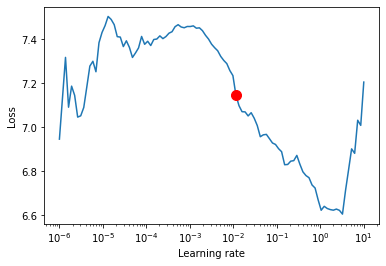

In [19]:
# find optimal learning rate

torch.set_grad_enabled(False)
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6
    )

print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [20]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,  # 7 quantiles by default
    loss=RMSE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Number of parameters in network: 299.1k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

Hyperparameter tuning

In [ ]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

Evaluate performance

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# best_model_path = trainer.checkpoint_callback.best_model_path
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)